# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [9]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv' 

In [10]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    X = pd.read_csv(path_to_csv)
    y = X.pop('label').map({'B': 1, 'M': 0})
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    X = pd.read_csv(path_to_csv)
    y = X.pop('label')
    return X, y

In [11]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [12]:
def train_test_split(X, y, ratio=0.9):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    
    full_size = len(X)
    train_size = int(ratio*full_size)
    X_train = X.sample(train_size)
    index_train = X_train.index
    y_train = y.loc[index_train]
    index_test = X.index.drop(index_train)
    X_test = X.loc[index_test]
    y_test = y.loc[index_test]
    
    return X_train, y_train, X_test, y_test
    

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [13]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    
    precision = []
    recall = []
    
    for pos in sorted(set(y_true) | set(y_pred)):
        tp, tn, fp, fn = 0, 0, 0, 0
    
        for p, t in zip(y_pred, y_true):
            if p == t:
                if p == pos:
                    tp += 1
                else:
                    tn += 1
            else:
                if p != pos:
                    fp += 1
                else:
                    fn += 1

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [14]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [15]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = knearest.predict_proba(X_test).iloc[:, 0] #[p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [16]:
class KDTree:
    def __init__(self, leaf_size):
        self.leaf_size = leaf_size
    
    def build(self, ds):
        self.ds = ds
        _, self.dimentions = ds.shape
        self._kdtree = self._build_helper(point_list=list(ds.index))
        
    def _build_helper(self, point_list, depth=0):
        if len(point_list) <= self.leaf_size:
            return list(point_list)

        axis = depth % self.dimentions
        col = self.ds.columns[axis]

        sorted_col_idx = self.ds.loc[point_list, col].sort_values().index
        median = len(sorted_col_idx) // 2

        return (
                sorted_col_idx[median], # slice point
                median, # num of points in left child
                len(sorted_col_idx) - median - 1, # num of point in right child
                self._build_helper(sorted_col_idx[:median], depth+1), # left child
                self._build_helper(sorted_col_idx[median+1:], depth+1), # right child
                )
    
    def find_neighbors(self, x, k):
        # Находит место в дереве для вершины x, содержащее не менее k других вершин
        
        current_node = self._kdtree
        depth = 0
        
        while not isinstance(current_node, list):
            split_point, num_left, num_right, left_child, right_child = current_node
        
            axis = depth % self.dimentions
            col = self.ds.columns[axis]
            depth += 1
    
            if x[col] < self.ds.loc[split_point, col] and num_left >= k:
                current_node = left_child
            elif x[col] > self.ds.loc[split_point, col] and num_right >= k:
                current_node = right_child
            else:
                break
                
        return self._flatten(current_node)
    
    def _flatten(self, tree):
        if isinstance(tree, list):
            return tree
        else:
            split_point, num_left, num_right, left_child, right_child = tree
            return self._flatten(left_child) + [split_point] + self._flatten(right_child)
        

In [17]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.kdtree = KDTree(leaf_size)
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.kdtree.build(X)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        res = pd.DataFrame(0, columns = self.y.unique(), index=X.index)
        
        for idx in X.index:
            neighbors = self.kdtree.find_neighbors(X.loc[idx], self.n_neighbors)
            distances2 = ((self.X - X.loc[idx]) ** 2).sum(axis=1)
            top_n_neighbors = list(distances2.sort_values().index[:self.n_neighbors])
           
            #if min(distances2)[0] == 0:
                # Если точка совпала с какой-то точкой в датасете, оставляем только её
            #    top_n_neighbors = top_n_neighbors[0]
            for n in top_n_neighbors:
                res.loc[idx, self.y[n]] += 1
                       
            res.loc[idx, :] /= self.n_neighbors       
        return res
            
        
    def predict(self, X):
        return self.predict_proba(X).idxmax(axis=1)


Наконец, протестируем наш классификатор на различных наборах данных

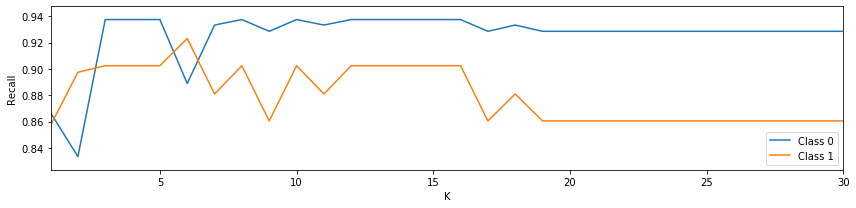

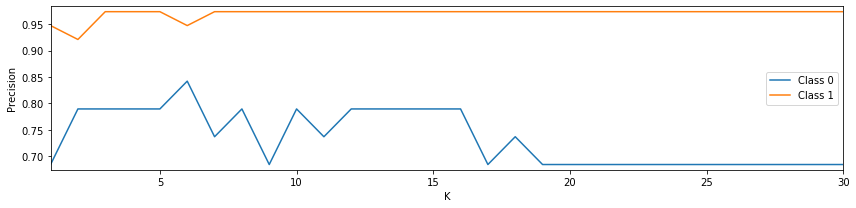

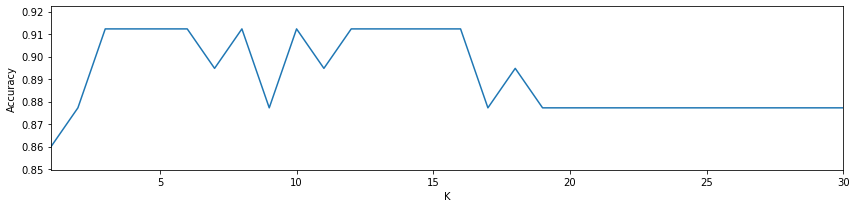

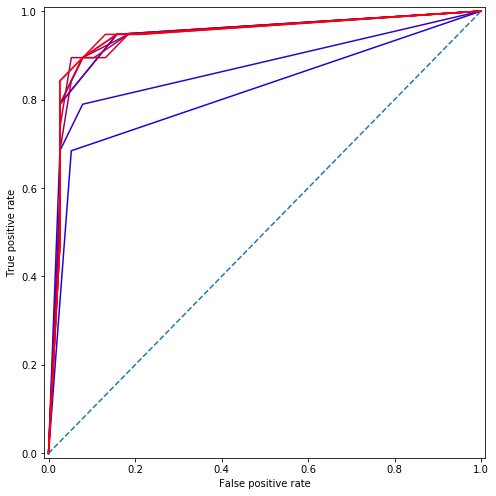

In [18]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

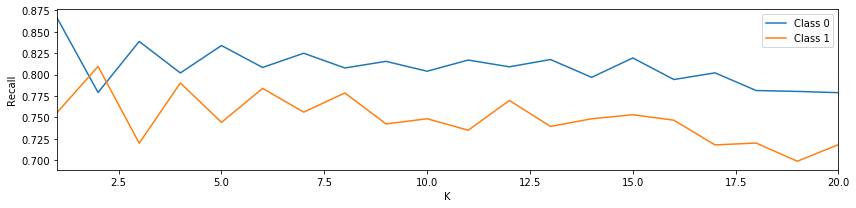

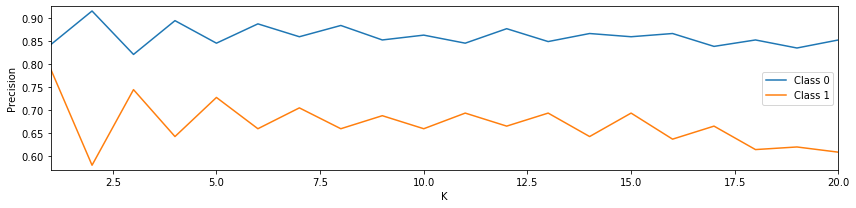

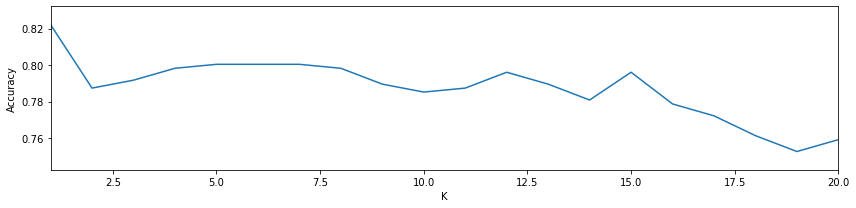

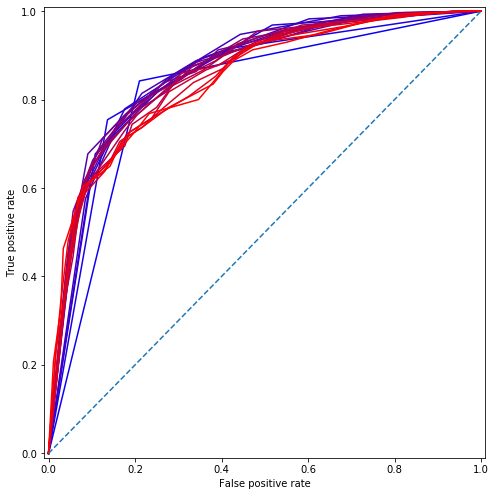

In [19]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

- Видимо k=5..7 для первой и k=5 для второй задач являются оптимальным, потому что при увеличении дальше - снижаются все показатели качества.
- Т.к. в задаче с раком мы дифференцируем между двумя типами опухолей, то я бы выбрал accuracy. Если бы речь была о тесте выявления рака вообще, т.е. здоров/подозрение на рак, то я бы выбрал recall, чтобы уменьшить вероятность ложноотрицательных результатов, потому что в этой задаче лучше перебдеть, чем недобдеть.
- В задаче о спаме я бы выбрал precision, чтобы уменьшить вероятность ложноположительного результата, потому что, видимо, пропустить настоящий спам во Входящие лучше, чем зарезать не-спам письмо, которое пользователь может и не увидеть.

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [20]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque, defaultdict

In [21]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

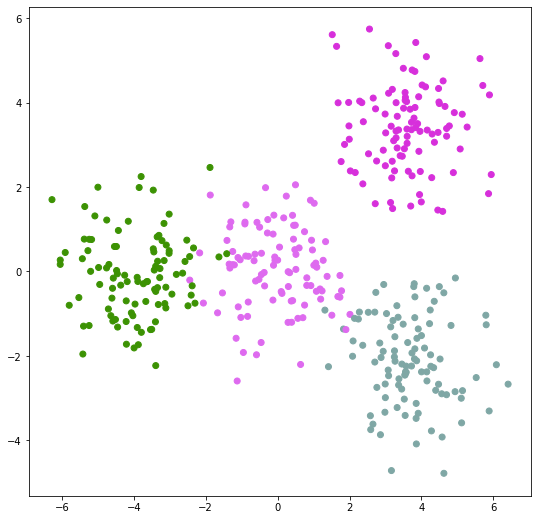

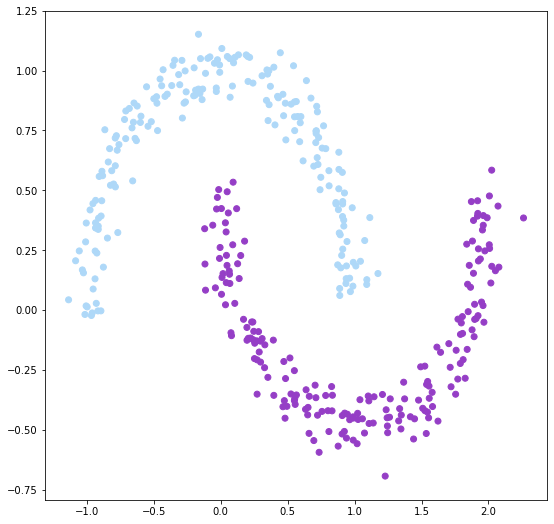

In [22]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [23]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.eps = 0.001
        
    def fit(self, X, y=None):
        n_points, self.dimentions = X.shape
        
        if self.init == 'random':
            low_bounds = X.min(axis=0)
            high_bounds = X.max(axis=0)
            self.centroids = np.hstack([(high_bounds[i] - low_bounds[i]) * np.random.rand(self.n_clusters, 1) + low_bounds[i] for i in range(self.dimentions)])
        elif self.init == 'sample':
            self.centroids = X[np.random.randint(low=0, high=n_points, size=self.n_clusters)]
        elif self.init == 'k-means++':
            self.centroids = X[[np.random.randint(low=0, high=n_points)]]
            M = np.zeros(n_points)
            for n in range(1, self.n_clusters):
                for i, point in enumerate(X):
                    M[i] = ((self.centroids - point) ** 2).sum(axis=1).min()
                new_point = np.random.choice(a=n_points, p=M/sum(M))
                self.centroids = np.append(self.centroids, X[[new_point]], axis=0)
            
           
        for _ in range(self.max_iter):
            clustered = defaultdict(list)
            for i, point in enumerate(X):
                cluster = ((self.centroids - point) ** 2).sum(axis=1).argmin()
                clustered[cluster].append(i)
            
            new_centroids = np.vstack([X[clustered[i]].mean(axis=0) for i in range(self.n_clusters)])
            max_shift = ((self.centroids - new_centroids) ** 2).sum(axis=1).max() ** (1/2)
            self.centroids = new_centroids
            
            if max_shift < self.eps:
                break
             
    
    def predict(self, X):
        n_points, self.dimentions = X.shape
        res = np.zeros(n_points, dtype=int)
        for i, point in enumerate(X):
            res[i] = ((self.centroids - point) ** 2).sum(axis=1).argmin()
        return res

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

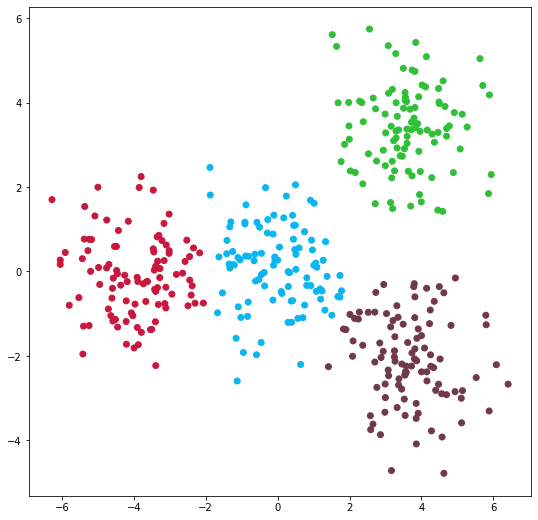

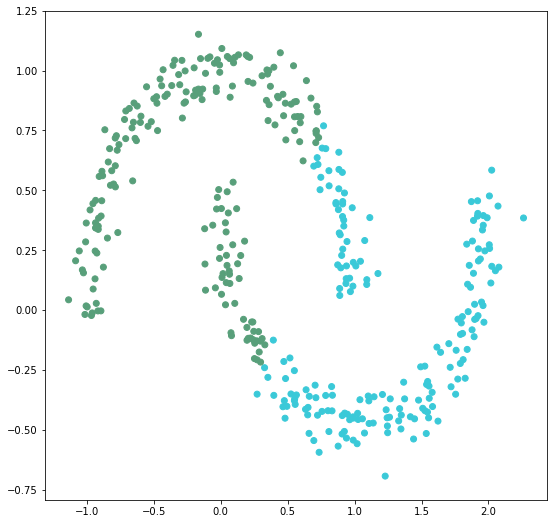

In [24]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
km_labels_1 = kmeans.predict(X_1)
visualize_clasters(X_1, km_labels_1)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
km_labels_2 = kmeans.predict(X_2)
visualize_clasters(X_2, km_labels_2)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [25]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        
        def expand_cluster(k, neighbours):
            clusters[k] = C
            clustered_points.add(k)
            while neighbours:
                q = neighbours.pop()
                if q not in visited_points:
                    visited_points.add(q)
                    nearest_neighbours = list(kd.query_radius([X[q]], r=self.eps)[0]) 
                    if len(nearest_neighbours) > self.min_samples:
                        neighbours.extend(nearest_neighbours)
                if q not in clustered_points:
                    clustered_points.add(q)
                    clusters[q] = C
                    
            
        noise = 0
        C = 0

        visited_points = set()
        clustered_points = set()
        clusters = [0] * len(X)
        
        kd = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
                       
        for i in range(len(X)):
            if i in visited_points:
                continue
            visited_points.add(i)
            neighbours = list(kd.query_radius([X[i]], r=self.eps)[0]) 
            if len(neighbours) < self.min_samples:
                clusters[i] = noise
            else:
                C += 1
                expand_cluster(i, neighbours)
                
        return clusters

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

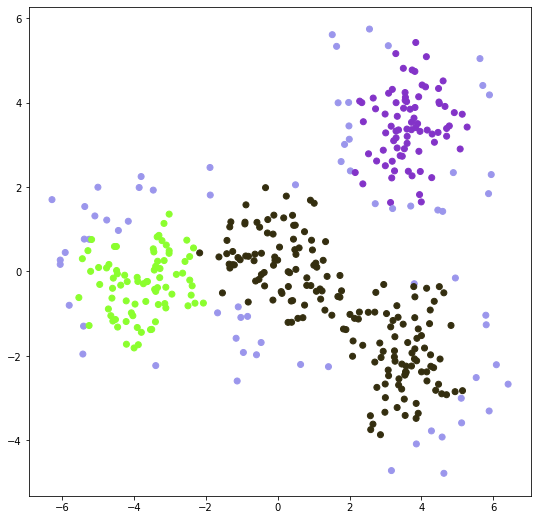

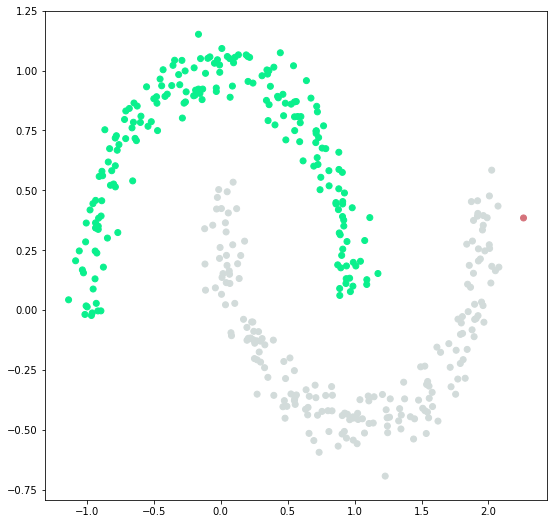

In [26]:
dbscan = DBScan(eps=0.7, min_samples=10)
dbs_labels_1 = dbscan.fit_predict(X_1)
visualize_clasters(X_1, dbs_labels_1)

dbscan = DBScan(eps=0.21, min_samples=20)
dbs_labels_2 = dbscan.fit_predict(X_2)
visualize_clasters(X_2, dbs_labels_2)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

_Ваш ответ_

In [27]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [28]:
print('Davies-Bouldin (меньше - лучше)')
print('\tk-means\n\t\tX_1 ', davies_bouldin_score(X_1, km_labels_1))
print('\t\tX_2 ', davies_bouldin_score(X_2, km_labels_2))
print('\tDBScan\n\t\tX_1 ', davies_bouldin_score(X_1, dbs_labels_1))
print('\t\tX_2 ', davies_bouldin_score(X_2, dbs_labels_2))
print('Silhouette (ближе к 1 - лучше)')
print('\tk-means\n\t\tX_1 ', silhouette_score(X_1, km_labels_1))
print('\t\tX_2 ', silhouette_score(X_2, km_labels_2))
print('\tDBScan\n\t\tX_1 ', silhouette_score(X_1, dbs_labels_1))
print('\t\tX_2 ', silhouette_score(X_2, dbs_labels_2))


Davies-Bouldin (меньше - лучше)
	k-means
		X_1  0.5817387505938139
		X_2  0.785062710924465
	DBScan
		X_1  2.629769497623977
		X_2  0.9461053911595991
Silhouette (ближе к 1 - лучше)
	k-means
		X_1  0.5677388687310944
		X_2  0.4841028032653283
	DBScan
		X_1  0.3429843265711417
		X_2  0.1729940401657714


Хотя метрики показывают, что k-means в обоих случаях лучше, визуально больше похоже на то, что k-means лучше для первого датасета, потому что кластеры там более-менее похоже на выпуклые, почти круглые облака, а DBScan лучше для второго, потому что там кластеры более неправильной формы и заходят друг в друга. Хотя с первым датасетом DBScan тоже справился неплохо, возможно, слишком много точек отнесено к шуму.

### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [29]:
from itertools import product, combinations
from collections import namedtuple

In [30]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = {'average': np.mean, 'single': np.min, 'complete': np.max}[linkage]
            
    def fit_predict(self, X, y=None):
        self.X = X
        self.point_distances = dict()
        self.cluster_distances = dict()
        self.n = len(self.X)
        self.Cluster = namedtuple('Cluster', 'children members')
        
        self.clusters = {i: self.Cluster({i}, {i}) for i in range(self.n)}
        self.active_clusters = list(range(self.n))
        
        self.n -= 1
        
        while len(self.active_clusters) > 1:
            all_distances = [(self.cluster_distance(A, B), A, B) for A, B in combinations(self.active_clusters, 2)]
            dist, A, B = min(all_distances)
            self.union(A, B)
        
        res_clusters = [self.n]
        while len(res_clusters) != self.n_clusters:
            m = max(res_clusters)
            res_clusters.remove(m)
            res_clusters.extend(self.clusters[m].children)
                
        labels = -np.ones(len(X), dtype=int)
        for label, cluster_id in enumerate(sorted(res_clusters, reverse=True)):
            for point in self.clusters[cluster_id].members:
                labels[point] = label
        
        assert all(labels != -1), 'Не все точки распределены по кластерам'
        
        return labels
    
    def point_distance(self, i, j):
        pair = frozenset( (i, j) )
        if pair not in self.point_distances:
            self.point_distances[pair] = ((self.X[i] - self.X[j]) ** 2).sum() ** (1/2)
        
        return self.point_distances[pair]
    
    def cluster_distance(self, A, B):
        pair = frozenset( (A, B) )
        if pair not in self.cluster_distances:
            all_distances = [self.point_distance(i, j) for i, j in product(self.clusters[A].members, self.clusters[B].members)]
            self.cluster_distances[pair] = self.linkage(all_distances)
        return self.cluster_distances[pair]
    
    def union(self, A, B):
        self.n += 1
        self.clusters[self.n] = self.Cluster({A, B}, self.clusters[A].members | self.clusters[B].members)
        self.active_clusters.remove(A)
        self.active_clusters.remove(B)
        self.active_clusters.append(self.n)
 
        delete_pair = [k for k in self.cluster_distances if (A in k) or (B in k)]
        for pair in delete_pair:
            del self.cluster_distances[pair]

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

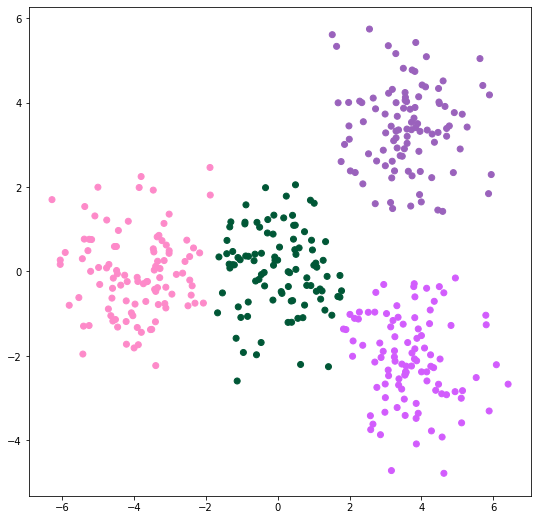

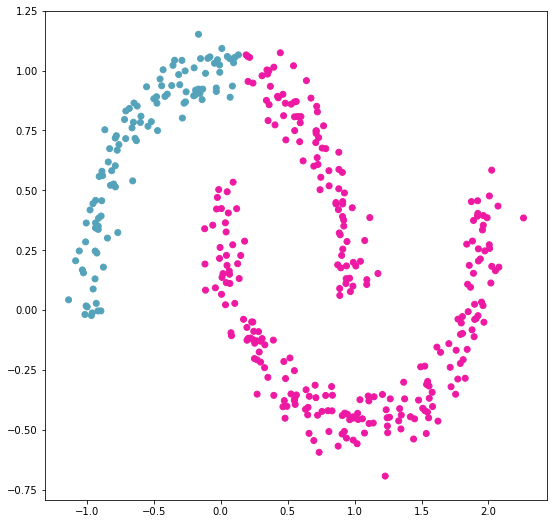

In [32]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
ac_labels1 = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, ac_labels1)

agg_clustering = AgglomertiveClustering(n_clusters=2)
ac_labels_2 = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, ac_labels_2)

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [34]:
print('Davies-Bouldin (меньше - лучше)')
print('\tk-means\n\t\tX_1 ', davies_bouldin_score(X_1, km_labels_1))
print('\t\tX_2 ', davies_bouldin_score(X_2, km_labels_2))
print('\tDBScan\n\t\tX_1 ', davies_bouldin_score(X_1, dbs_labels_1))
print('\t\tX_2 ', davies_bouldin_score(X_2, dbs_labels_2))
print('\tAgglomertiveClustering\n\t\tX_1 ', davies_bouldin_score(X_1, ac_labels1))
print('\t\tX_2 ', davies_bouldin_score(X_2, ac_labels_2))
print('Silhouette (ближе к 1 - лучше)')
print('\tk-means\n\t\tX_1 ', silhouette_score(X_1, km_labels_1))
print('\t\tX_2 ', silhouette_score(X_2, km_labels_2))
print('\tDBScan\n\t\tX_1 ', silhouette_score(X_1, dbs_labels_1))
print('\t\tX_2 ', silhouette_score(X_2, dbs_labels_2))
print('\tAgglomertiveClustering\n\t\tX_1 ', silhouette_score(X_1, ac_labels1))
print('\t\tX_2 ', silhouette_score(X_2, ac_labels_2))

Davies-Bouldin (меньше - лучше)
	k-means
		X_1  0.5817387505938139
		X_2  0.785062710924465
	DBScan
		X_1  2.629769497623977
		X_2  0.9461053911595991
	AgglomertiveClustering
		X_1  0.5837454872542895
		X_2  0.7374622897920768
Silhouette (ближе к 1 - лучше)
	k-means
		X_1  0.5677388687310944
		X_2  0.4841028032653283
	DBScan
		X_1  0.3429843265711417
		X_2  0.1729940401657714
	AgglomertiveClustering
		X_1  0.5651338832166874
		X_2  0.43740806480169314


AgglomertiveClustering примерно на равне в k-means. Визуально он справился с первым датасетом не хуже k-means, а со вторым - примерно так же плохо и видимо по тем же причинам. Всё-таки странно, что метрики DBScan отстают по второму датасету.